# 20180930 Update

- reorg codes
	- flex
	- clearness
	- we should memic the strucutr of DiDi's OD flow prediction model code:
		- one function -> build model (different model strucutre)
		- one function -> train the model (specify small/large UCF or other dataset)
		- oen function -> inquiry on UCF
		- one function get accuracy description and save to txt
- run experiments
	- DTW vs. simple matching (need 2 differnt length of video in inquiry set)
	- ConvLSTM vs. LSTM vs. Conv2D (sort of frame based VGG ) vs. (VidSig) (Non-DL method)

# A simple test for inquiry model


Here is the setting:

- My thought: Yintai Ma [09:23] 
  - Suppose I have a video X of 100 frames, denoting as X[0] to X[99]. We then split it to multiple clips without overlap. If then length of each clip is 5 frames, then we come up with a sequences of clips X[0:5],X[5:10],...,X[95:100]. We use the encoder to transfer the sequences of clips to sequences of embeddeds, reads y[0],y[1],...,y[20]. Now we randomly pick some frames from X as validation clip and transfer it into validation embedded y_hat. We want to see how y_hat is matching to the sequences of y[0]...y[20].

- Diego:
  - You have video X. Randomly pick  sequences of frames (non overlapping). Say x[4:10], x[34:37],x[85:95]. Now concatenate them into a single video. This is now your query. From here, create embedding sequence y[0],…y[K]. Now do DTW of y against your encoded sequences of the videos in the database.
  - This is subject to experimentation. I agree that there should be overlap. Overlap by half.

- My thought: There are many variations for the implementation:
  1. we keep overlaps for y. We transfer X[0:5],X[1:6],....X[94:99],X[95:100] into y[0]...y[100]. Now we want to see how y_hat is matching to y[].
  2. When we pick some frames from X to composite validation clips, do we always pick 5 consecutive frames? Should we ever transfer X[0]+X[2:6] into y_hat?
  3. How we match y_hat to y[] if y_hat is also a sequences? I think this is where DTW comes in right? If y_hat is just one embedded, then what we need is basically a simple comparison between the distance of two embedded. However, if y_hat is a sequences, say it has y_hat[0] and y_hat[1], then we will need to use DTW to consider the case where both y_hat[0] matches to y[0] and y_hat[1] matches to y[3] are the best query retrieve.


In [1]:
import sys,os,os.path
sys.path.append(os.path.expanduser('/home/lab.analytics.northwestern.edu/yma/git/videodl/seq_inquiry'))
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
import keras
from keras.models import load_model
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LSTM, RepeatVector
from keras.layers.wrappers import *
from keras.layers.core import *
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.optimizers import RMSprop
from keras import backend as K

import csv
import os
import time
import sys
import numpy as np
import matplotlib
# matplotlib.use('Agg')
import pylab as plt
# from scipy.misc import toimage

import imageio
import cv2
import numpy as np
import numpngw
import pandas as pd 

from IPython.display import HTML
import random

/home/lab.analytics.northwestern.edu/yma/.conda/envs/dl/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/lab.analytics.northwestern.edu/yma/.conda/envs/dl/lib/python2.7/site-packages/scipy/optimize/_minimize.py:32: ImportWarning: Not importing directory '/home/lab.analytics.northwestern.edu/yma/.conda/envs/dl/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb
/home/lab.analytics.northwestern.edu/yma/.conda/envs/dl/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: ImportWarning: Not importing directory '/home/lab.analytics.northwestern.edu/yma/.conda/envs/dl/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *

In [1]:
GENERATE_DATA = 1 
LOG_DIR = "../../tensorboard/log/"
EPOCH = 150
sequenceLength = 3
setup_name = "clrmvsq_simple_vgg_a"
N_SAMPLES = 1000
BATCHSIZE = 5
ucf_generate_fps = 2  # The fps to sample from the original UCF data to generate the train and val set
# data_path = "../../data/UCF/"
data_path = "/scratch/yma/git/five-video-classification-methods/data"

batch_size=20
data_type = 'images'
concat=False


# Load trained model


In [3]:
# print("--- Start Assembling the Model ---")

# inputs = Input(shape=(sequenceLength,224,224,3))

# # conved = TimeDistributed(Lambda(MyCNN), input_shape=(sequenceLength,40,40,1)) (inputs)

# x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1'), input_shape=(sequenceLength,224,224,3))(inputs)
# x = TimeDistributed(MaxPooling2D((2, 2), name='block1_pool'))(x)
# # x = TimeDistributed(MaxPooling2D((2, 2)))(x)
# x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'))(x)
# x = TimeDistributed(MaxPooling2D((2, 2), name='block2_pool'))(x)
# x = TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'))(x)
# x = TimeDistributed(MaxPooling2D((2, 2), name='block3_pool'))(x)
# x = TimeDistributed(Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'))(x)
# x = TimeDistributed(MaxPooling2D((2, 2), name='block4_pool'))(x)
# x = TimeDistributed(Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1'))(x)

# # LSTM part
# x = TimeDistributed(MaxPooling2D((2, 2), name='block5_pool'))(x)
# # x = TimeDistributed(Flatten())(x)

# encoded = ConvLSTM2D(filters=100, kernel_size=(3, 3),padding='same', return_sequences=True)(x)

# encoder = Model(output=encoded,input=inputs)
# # myoptmizer = RMSprop(lr=0.1, decay=1e-4)
# # autoencoder.compile(loss='mean_squared_error', optimizer=myoptmizer)
# encoder.compile(loss='mean_squared_error', optimizer='RMSprop')

# # plot_model(encoder, to_file='query_model.png', show_shapes=True)

# print('--- Finish Compile and Plot Model ---')

In [4]:
# weights_file = "/home/lab.analytics.northwestern.edu/yma/git/data/checkpoints/ucf_simple_vgg16_seq3_convlstm_c5.002-0.0186.hdf5"
# encoder.load_weights(weights_file, by_name=True)


# model_file = "/home/lab.analytics.northwestern.edu/yma/git/data/checkpoints/ucf_simple_vgg16_seq3_convlstm_c5.002-0.0186.hdf5"
model_file = "/home/lab.analytics.northwestern.edu/yma/git/data/checkpoints/ucf_vgg16_seq3_convlstm_c5.001-0.0570.hdf5"
encoder = load_model(model_file)




TypeError: ('Keyword argument not understood:', u'implementation')

## Code Start from here

In [113]:
SEQ_LENGTH = 3
# the number of frames in each clip

# N_database = 500
# N_database = 5
N_database = 50

inq_length = 8
# the number of clips in the inquiry, no overlap

DATASET_CLASS_LIMIT = 50
# number of class is the dataset

FLAG_RANDOM_CLASS = True
# whether randomly pick classes in the dataset


In [114]:

def create_database(data):
    database = []
    for i in range(0, N_database):
        smp = data.data[i]
        # ['train', 'BaseballPitch', 'v_BaseballPitch_g25_c06', '123']
        vid_len = int(smp[3])
        frams = data.get_frames_for_sample(smp,data.data_dir)
        seq = data.build_image_sequence(frams)
        seq = np.array(seq)
        seqX = []
        print('Idx:', "%d/%d"%(i, N_database),  smp[2], 'Length:' , len(seq)-SEQ_LENGTH,'Jump:', (SEQ_LENGTH>>1)+1 )
        for j in range(0,len(seq)-SEQ_LENGTH, (SEQ_LENGTH>>1)+1):
            seqX.append(seq[j:j+SEQ_LENGTH])
        seqX = np.array(seqX)
        seqY = encoder.predict(seqX)
        database.append((seqY, smp[2]))
    return database
        

In [115]:
import random
def get_inquiry(data, if_random=True, pos = 0):
    if if_random:
        index = np.random.choice(len(data.data))
        smp = data.data[index]
    else:
        smp = data.data[pos]
    
    vid_len = int(smp[3])
    frams = data.get_frames_for_sample(smp, data.data_dir)
    frams = data.rescale_list(frams, vid_len-1)
    seq = data.build_image_sequence(frams)
    seq = np.array(seq)
    
    seqX = []
    X_frames_start= []
    stepsize = vid_len / inq_length - 2
    for j in range(0, inq_length):
        jst = j*stepsize
        jend = j*stepsize+SEQ_LENGTH
        seqX.append(seq[jst:jend])
        X_frames_start.append((jst, jend))
    seqX = np.array(seqX)
    seqY = encoder.predict(seqX)
    return (seqX, seqY ,smp[2], X_frames_start)


In [116]:
def get_dist(vec_i, vec_j):
    return np.linalg.norm(vec_i - vec_j, ord=1)

    
def sum_dist(vecs_i, vecs_j):
    assert len(vecs_i) == len(vecs_j)
    _sum = 0
    for i in range(0, len(vecs_i)):
        _sum += get_dist( vecs_i[i], vecs_j[i])
    return _sum

    
def get_next_ij(dist, i , j):
    moves = [(0,-1), (-1,0), (-1,-1)]
    min_value = np.inf
    best_inci = -1 if i >0 else 0
    best_incj = -1 if j >0 else 0
    for (inci, incj) in moves:
        if i+inci >= 0 and j+incj >=0 and dist[i+inci, j+incj] < min_value:
            (best_inci, best_incj) = (inci, incj)
            min_value = dist[i+inci, j+incj]
    return (i+best_inci, j+best_incj)
        
def getBestDTWRoute(dist):
    (i,j) = dist.shape
    i=i-1
    j=j-1
    route = []
    path_i = []
    path_j = []
    while i!=0 or j!=0:
        route.append( (i,j) )
        path_i.append(i)
        path_j.append(j)
        i_next, j_next = get_next_ij(dist,i,j)
        (i,j) = (i_next, j_next)
#     for combos in route:
#         print(combos, "->")
#     path_i = path_i.reverse()
#     path_j = path_j.reverse()
    return (np.array(path_i), np.array(path_j))
        
def DTWdistance(s1,s2):
    n1 = len(s1)
    n2 = len(s2)
    dist = np.zeros((n1,n2))
    cost = np.zeros((n1,n2))
    dist[:,0] = np.inf
    dist[0,:] = np.inf
    dist[0,0] = 0
#     print("n1 n2", n1, n2)
    for i in range(0,n1):
        for j in range(0,n2):
#             print(i,j)
            cost[i,j] = get_dist(s1[i], s2[j])
            dist[i,j] = cost[i,j] + min(dist[i-1,j], dist[i,j-1], dist[i-1,j-1])
    path = getBestDTWRoute(dist)
    return dist[n1-1, n2-1], cost, dist, path

def NaiveMatch(cost):
    (n,m) = cost.shape
    min_sum = np.inf
    assert n<m
    for startj in range(0, m-n+1):
        _sum = 0
        starti = 0
        for pos in range(0, n):
            _sum += cost[starti+pos, startj+pos]
        if _sum < min_sum:
            min_sum = _sum
    return min_sum
    

def inquiry_in_database(inquiry_seqY, database, match_method = "dtw"):
    scores= []
    score_names = []
    bestscore = 1<<30
#     dist, cost, acc, path
    for i in database:
#         print(inquiry_seqY.shape) 8 * 14470
#         print(i[0].shape) ~50 * 14470
        seqyflat = inquiry_seqY.reshape((inquiry_seqY.shape[0], -1))
        iyflat = i[0].reshape((i[0].shape[0], -1))
        dist, cost, acc, path = DTWdistance(seqyflat, iyflat)            
        if match_method == "dtw":
            dist = dist
        elif match_method == "naive":
            # slide the inqury sequence over the candidate video to find the minimal match position
            dist = NaiveMatch(cost)
            
        scores.append((dist,i[1]))
        if dist< bestscore:
            bestscore = dist
            bestpath = path
            bestacc= acc
            bestfilename = i[1]
            
    scores = sorted(scores, key=lambda x:x[0])
    
    res_dict = {}
    res_dict["bestscore"] = bestscore
    res_dict["bestacc"] = bestacc
    res_dict["bestpath"] = bestpath
    res_dict["bestfilename"] = bestfilename
    res_dict["scores"] = scores
    return res_dict

def show_inquriy_stats(inqs, inq_result, show_top_limit = 10):
    print("Inqury is:\t"+ inqs[2])
    print("Inqury frames:\t"+ str(inqs[3]))
    print("Best Match is:\t"+ inq_result["bestfilename"])
    print("Best Dist:\t"+ str(inq_result["bestscore"]))

    acc = inq_result["bestacc"]
    path = inq_result["bestpath"]
    imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
    plot(path[0], path[1], 'w')
    # xlim((-0.5, acc.shape[0]-0.5))
    # ylim((-0.5, acc.shape[1]-0.5))

    print("========================")
    print("All scores in database:")
    for i in range( min(show_top_limit, len(inq_result["scores"])) ):
        print("Record: "+ inq_result["scores"][i][1].ljust(25)+ "\tDTW Dist: "+ str(inq_result["scores"][i][0]))



In [117]:
def initilize(data_path = data_path, seq_length=SEQ_LENGTH, class_limit=DATASET_CLASS_LIMIT, random_class = FLAG_RANDOM_CLASS):
    # Initilize 

    import data_seq
    from scipy.spatial.distance import euclidean
    from dtw import dtw
    %pylab inline

    data_seq = reload(data_seq)
    data = data_seq.DataSet(data_dir = data_path, seq_length=seq_length,class_limit=class_limit, random_class=random_class)
    random.shuffle(data.data)
    print("Number of records in database:", len(data.data))
    database = create_database(data)
    # database.append((seqY, smp[2]))
    return database

In [118]:
def get_category(str):
    return str.split('_')[1]
def multiple_test(data,run_times=100, if_itself=True):
    # how many top result will be counted
    Count_tops = 5
    
    Total_run = run_times
    # Tops_same_count: number of same category as inq appeared in result list
    Tops_same_count = [0.0] * Count_tops

    # Tops_same_ever_hit: if the same category as inq has appeared in result list of top N
    Tops_same_ever_hit = [0.0] * Count_tops
    
    # Sum of Score of Nth element of return list
    Nth_score_sum = [0.0] * Count_tops
    Hit_itself_sum = [0.0] * Count_tops
    self_pos_sum = 0
    
    run_times = min(run_times, len(data.data)-N_database)

    if if_itself:
        stpos = 0
    else:
        stpos = N_database
#     print(stpos)
    
    for i in range(0, run_times):
        if i %1 == 0:
            print("%d/%d Runs."%(i, run_times))
            
        inqs = get_inquiry(data, if_random = False, pos= stpos+i)
        seqY = inqs[1]
        inq_result = inquiry_in_database(seqY, database)
        for j in range(0, Count_tops):
            if(get_category(inq_result["scores"][j][1]) == get_category(inqs[2])):
                for k in range(j, Count_tops):
                    Tops_same_count[k] += 1
#                 break

        for j in range(0, Count_tops):
            if(get_category(inq_result["scores"][j][1]) == get_category(inqs[2])):
                for k in range(j, Count_tops):
                    Tops_same_ever_hit[k] += 1
                break
            
                
        for j in range(0, Count_tops):
            Nth_score_sum[j] += inq_result["scores"][j][0]
            if(inq_result["scores"][j][1] == inqs[2]):
                Hit_itself_sum[j] += 1
            
    top_cat_same = [x/Total_run for x in Tops_same_count]
    top_cat_same_hit = [x/Total_run for x in Tops_same_ever_hit]
    Nth_score_avg = [x/Total_run for x in Nth_score_sum]
    Hit_itself_avg = [x/Total_run for x in Hit_itself_sum]
    
    res_dict = {}
    res_dict["top_cat_same"] = top_cat_same
    res_dict["top_cat_same_hit"] = top_cat_same_hit
    res_dict["Nth_score_avg"] = Nth_score_avg
    res_dict["Hit_itself_avg"] = Hit_itself_avg
    
    print("top_cat_same: ", top_cat_same)
    print("top_cat_same_hit: ", top_cat_same_hit)
    print("Nth_score_avg: ", Nth_score_avg)
    print("Hit_itself_avg: ", Hit_itself_avg)
    
    return res_dict


In [119]:
database = initilize()

Populating the interactive namespace from numpy and matplotlib
('Number of records in database:', 5897)
('Idx:', '0/50', 'v_SkateBoarding_g15_c02', 'Length:', 127, 'Jump:', 2)
('Idx:', '1/50', 'v_HammerThrow_g06_c03', 'Length:', 157, 'Jump:', 2)
('Idx:', '2/50', 'v_Archery_g24_c02', 'Length:', 239, 'Jump:', 2)
('Idx:', '3/50', 'v_YoYo_g08_c01', 'Length:', 186, 'Jump:', 2)
('Idx:', '4/50', 'v_JavelinThrow_g23_c04', 'Length:', 133, 'Jump:', 2)
('Idx:', '5/50', 'v_HeadMassage_g20_c05', 'Length:', 103, 'Jump:', 2)
('Idx:', '6/50', 'v_YoYo_g14_c04', 'Length:', 163, 'Jump:', 2)
('Idx:', '7/50', 'v_WritingOnBoard_g15_c05', 'Length:', 226, 'Jump:', 2)
('Idx:', '8/50', 'v_UnevenBars_g17_c03', 'Length:', 132, 'Jump:', 2)
('Idx:', '9/50', 'v_GolfSwing_g25_c02', 'Length:', 127, 'Jump:', 2)
('Idx:', '10/50', 'v_HeadMassage_g18_c04', 'Length:', 257, 'Jump:', 2)
('Idx:', '11/50', 'v_HandstandWalking_g15_c03', 'Length:', 203, 'Jump:', 2)
('Idx:', '12/50', 'v_Basketball_g09_c03', 'Length:', 82, 'Jump:'

Inqury is:	v_HandStandPushups_g25_c01
Inqury frames:	[(0, 3), (15, 18), (30, 33), (45, 48), (60, 63), (75, 78), (90, 93), (105, 108)]
Best Match is:	v_WallPushups_g19_c01
Best Dist:	23197.532470703125
All scores in database:
Record: v_WallPushups_g19_c01    	DTW Dist: 23197.532470703125
Record: v_WallPushups_g19_c04    	DTW Dist: 23317.1748046875
Record: v_PlayingDhol_g07_c04    	DTW Dist: 24242.6728515625
Record: v_WritingOnBoard_g23_c03 	DTW Dist: 24594.572265625
Record: v_WritingOnBoard_g15_c05 	DTW Dist: 25441.063232421875
********************
********************
********************
Inqury is:	v_HandStandPushups_g25_c01
Inqury frames:	[(0, 3), (15, 18), (30, 33), (45, 48), (60, 63), (75, 78), (90, 93), (105, 108)]
Best Match is:	v_WallPushups_g19_c01
Best Dist:	22134.832275390625
All scores in database:
Record: v_WallPushups_g19_c01    	DTW Dist: 22134.832275390625
Record: v_WallPushups_g19_c04    	DTW Dist: 22166.397216796875
Record: v_PlayingDhol_g07_c04    	DTW Dist: 23328.940

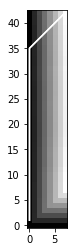

In [124]:
inqs = get_inquiry(data, if_random = True)

seqY = inqs[1]
inq_result = inquiry_in_database(seqY, database)
show_inquriy_stats(inqs, inq_result, show_top_limit = 5)

print("*"*20)
print("*"*20)
print("*"*20)

inq_result = inquiry_in_database(seqY, database, match_method = "naive")
show_inquriy_stats(inqs, inq_result, show_top_limit = 5)

In [101]:
# (top_cat_same,top_cat_same_hit, Nth_score_avg, Hit_itself_avg) = multiple_test(data, run_times=100, if_itself=False)

res_dict = multiple_test(data, run_times=5, if_itself=False)

0/5 Runs.
1/5 Runs.
2/5 Runs.
3/5 Runs.
4/5 Runs.
([0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [27576.09453125, 31657.386083984376, 34039.05859375, 40437.35498046875, 43974.799609375], [0.0, 0.0, 0.0, 0.0, 0.0])


In [ ]:
# # 100 yes
# # ([1.0, 1.6, 1.9, 2.11, 2.31], 
# [1.0, 1.0, 1.0, 1.0, 1.0], 
# [477.99725810013655, 1569.801293508719, 1983.8946612704194, 2173.4673165842296, 2239.76024740403],
# [1.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
# # 100 No it self
# ([0.67, 1.07, 1.28, 1.5, 1.68], 
#  [0.67, 0.72, 0.75, 0.78, 0.78], 
#  [1468.9675286393074, 1990.4723390313206, 2219.1774095071487, 2314.7653604314573, 2373.6116836425554],
#  [0.0, 0.0, 0.0, 0.0, 0.0])